In [27]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import shutil
import pywt
import os

#link = r'C:\Users\Hamza\Desktop\model\Model\testImages\1.jpg'


def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color


#cropped_image = get_cropped_image_if_2_eyes(link)
#plt.imshow(cropped_image)

############################### LOADING openCV CASCADE PRETRAINED CLASSSIFIERS  ######################################
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_eye.xml')

path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
        
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)#if folder exist remove it
os.mkdir(path_to_cr_data)
        
cropped_image_dirs = []
politician_file_names_dict = {}

for img_dir in img_dirs:
    politician_name = img_dir.split('/')[-1]
    
    
for img_dir in img_dirs:
    count = 1
    politician_name = img_dir.split('/')[-1]
    print(politician_name)
    
    politician_file_names_dict[politician_name] = [] #politician name is a key and value is alist of pictures
    
    for entry in os.scandir(img_dir):#each image in given politician name directory
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + politician_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = politician_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            politician_file_names_dict[politician_name].append(cropped_file_path)
            count += 1

angela_merkel
Generating cropped images in folder:  ./dataset/cropped/angela_merkel
donald_trump
Generating cropped images in folder:  ./dataset/cropped/donald_trump
imran_khan
Generating cropped images in folder:  ./dataset/cropped/imran_khan
kim_jong-un
Generating cropped images in folder:  ./dataset/cropped/kim_jong-un
narendra_modi
Generating cropped images in folder:  ./dataset/cropped/narendra_modi
vladimir_putin
Generating cropped images in folder:  ./dataset/cropped/vladimir_putin
xi_jinping
Generating cropped images in folder:  ./dataset/cropped/xi_jinping


In [28]:
#after manually deleting the pictures our values of politician_file_names_dict affected for each value we need to deal with it
politician_file_names_dict = {}
for img_dir in cropped_image_dirs:
    politician_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    politician_file_names_dict[politician_name] = file_list

#first assigning each class a number before data generation and classification 
            
class_dict = {}
count = 0
for politician_name in politician_file_names_dict.keys():
    class_dict[politician_name] = count
    count = count + 1
class_dict

X, y = [], []
for politician_name, training_files in politician_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[politician_name])
        

In [29]:
len(X[0])


4096

In [30]:
X = np.array(X).reshape(len(X),4096).astype(float)#making sure every value is in float so we don't have problems working with classifier



In [31]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7761194029850746

In [33]:
print(classification_report(y_test, pipe.predict(X_test)))


              precision    recall  f1-score   support

           0       0.81      0.93      0.87        14
           1       1.00      0.50      0.67         4
           2       1.00      0.71      0.83         7
           3       0.67      0.40      0.50         5
           4       0.83      0.62      0.71         8
           5       0.69      0.96      0.80        23
           6       1.00      0.50      0.67         6

    accuracy                           0.78        67
   macro avg       0.86      0.66      0.72        67
weighted avg       0.81      0.78      0.76        67



In [34]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [35]:
#creating dictinary to keep each algo where algo  is key it's value is another dictinary where keys are model and param wwhere
# model key has classifer as vlaue but key params has dictionary as vlaue of params
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [36]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.858974,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.727821,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.944487,{'logisticregression__C': 1}


In [37]:
best_estimators['svm'].score(X_test,y_test)

0.835820895522388

In [38]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8507462686567164

In [39]:
#clearly best estimator is logistic regression based on both on CV and test set accuracy lets save that to best_clf
best_clf = best_estimators['logistic_regression']

Text(69.0, 0.5, 'Truth')

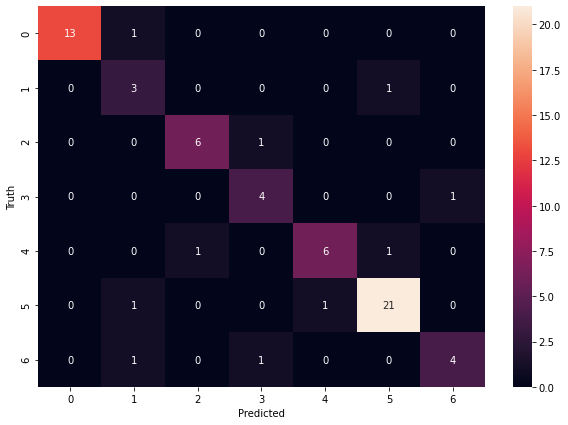

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [41]:
class_dict

{'angela_merkel': 0,
 'donald_trump': 1,
 'imran_khan': 2,
 'kim_jong-un': 3,
 'narendra_modi': 4,
 'vladimir_putin': 5,
 'xi_jinping': 6}

In [42]:
#lets save our model
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

In [43]:
#lets alose save our class_dict it will be useful later on
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))